# Overview:

We will use data from 2010 to 2020 to predict the  Adjusted Close values for the next quarter.

Make a datetime index using the Date column with a business day frequency ('B')

Check for and address null values.

Check the time series for stationarity.
- Determine the number of differencing (d) needed to make the data stationary. (We recommend using pmdarima's ndiffs)

Use ACF/PACF plots of the stationary data to estimate initial time series model orders​ (p,d,q)

Split the time series into training and test data. Use a test_size of one quarter (13 weeks X 5 business days)

Fit an ARIMA model based on the orders determined during your exploration.
- Make forecasts with your model.
- Plot the forecasts versus the test data.
- Obtain metrics for evaluation.

Try at least one variation of the model for comparison (we recommend using a loop to try combinations of model orders)

A MAPE of less than 2% on the test data is achievable.

Choose a final model and explain:
- How good was your model, according to your Mean Absolute Percentage Error?
- How good was your model in terms of how well the forecast seems to follow the test data, visually?  (Hint: You may want to plot fewer training data lags to see this)

## Imports/Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
import itertools

import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

plt.rcParams['figure.figsize'] = (12,3)

## Functions

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])



In [17]:
### NEW FUNCTION FOR COMBINED ACF/PACF WITH ANNOTATIONS
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [23]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

## Load Data

In [5]:
df = pd.read_csv('Data/WMT.csv')
df.head()

,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5479 non-null   object 
 1   Adj Close  5284 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.7+ KB


# Transform Data

### Datetime + Frequency

In [7]:
df["Date"] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5479 non-null   datetime64[ns]
 1   Adj Close  5284 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 85.7 KB


In [8]:
df = df.set_index('Date')
df.head()

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828


In [9]:
#Check for existing freq
df.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=5479, freq=None)

In [10]:
#resample for business days
df = df.resample('B').asfreq()
df.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=5479, freq='B')

## Null Values

In [11]:
# Check for null
df.isna().sum()

Adj Close    195
dtype: int64

In [12]:
# Interpolate the null data
df = df.interpolate()
df.isna().sum()

Adj Close    0
dtype: int64

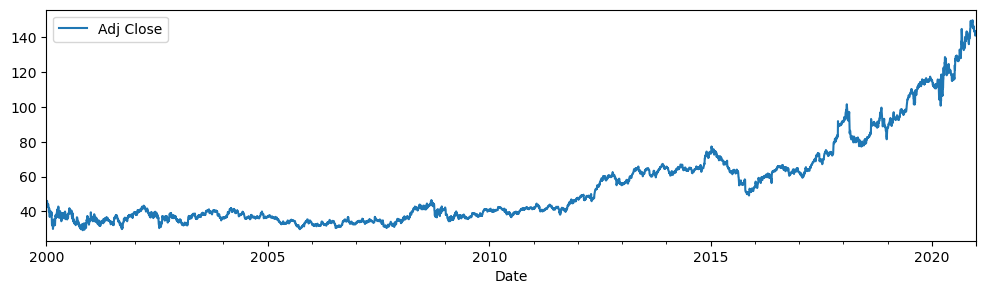

In [13]:
df.plot();

## Stationarity

In [14]:
adfuller_results = get_adfuller_results(df, label = 'Walmart')
adfuller_results

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
Walmart,2.575671,33,5445,0.99907,0.05,False


In [15]:
diff = ndiffs(df)
diff

2

In [19]:
df_diff = df.diff().diff().dropna()

## ACF/PACF

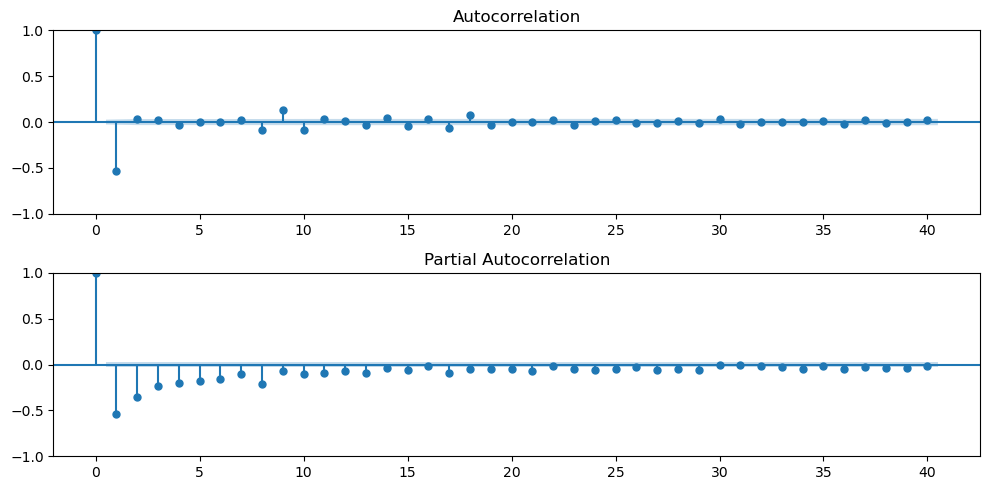

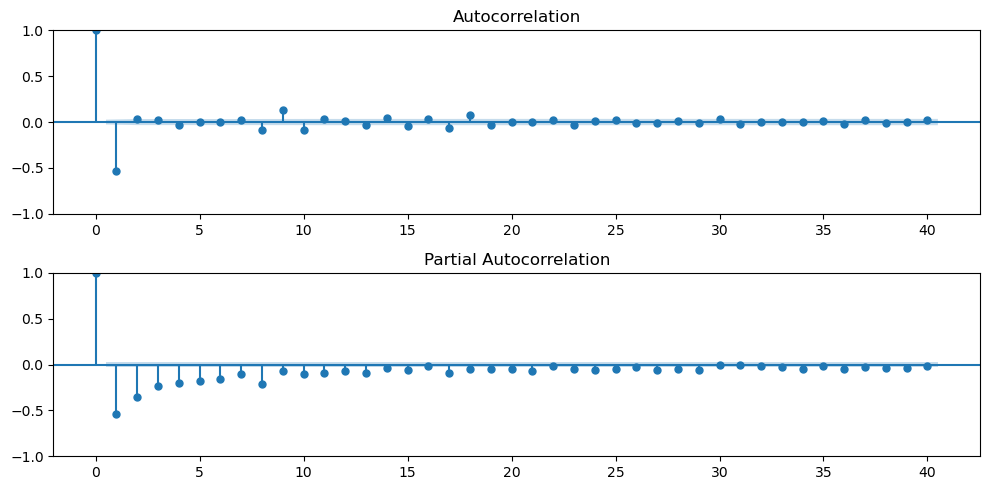

In [20]:
plot_acf_pacf(df_diff)

# Modeling

## Train/Test Split

In [21]:
test_size = 5*13

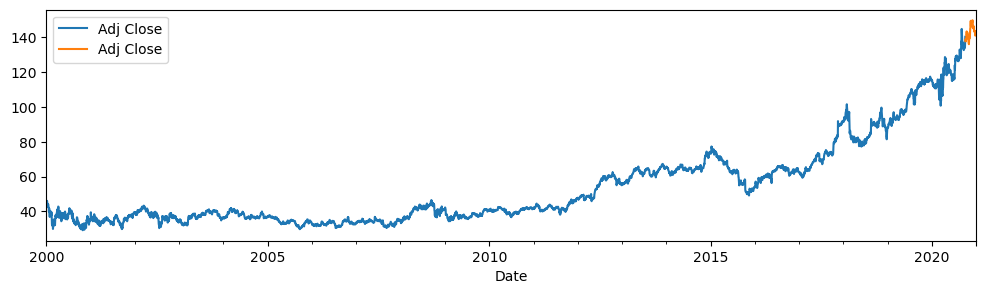

In [25]:
train, test = train_test_split(df, test_size=test_size)
ax = train.plot(label = 'Train')
test.plot(ax=ax, label = 'Test')
ax.legend();

## Model 1:

In [26]:
#p/d/q
p = 0
d = 2
q = 2
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.709
- MSE = 12.284
- RMSE = 3.505
- R^2 = 0.041
- MAPE = 1.87%


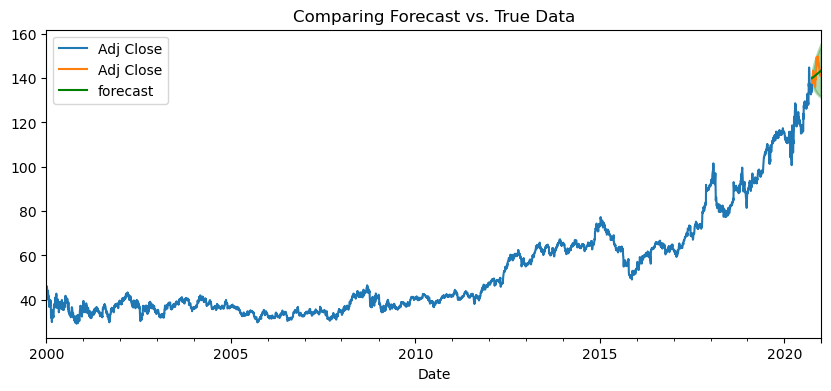

In [27]:
#summary
forecast = arima_model.get_forecast(len(test)).summary_frame()

#plot - forecast
plot_forecast(train, test, forecast)

regression_metrics_ts(test, forecast['mean'])

In [28]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 5414
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -6575.940
Date:                Fri, 03 Nov 2023   AIC                          13157.880
Time:                        03:07:42   BIC                          13177.669
Sample:                    01-03-2000   HQIC                         13164.788
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0899      0.004   -255.945      0.000      -1.098      -1.082
ma.L2          0.0907      0.004     21.693      0.000       0.083       0.099
sigma2         0.6643      0.003    199.176      0.000       0.658       0.671
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            212580.39
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.01   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Diagnostic plots

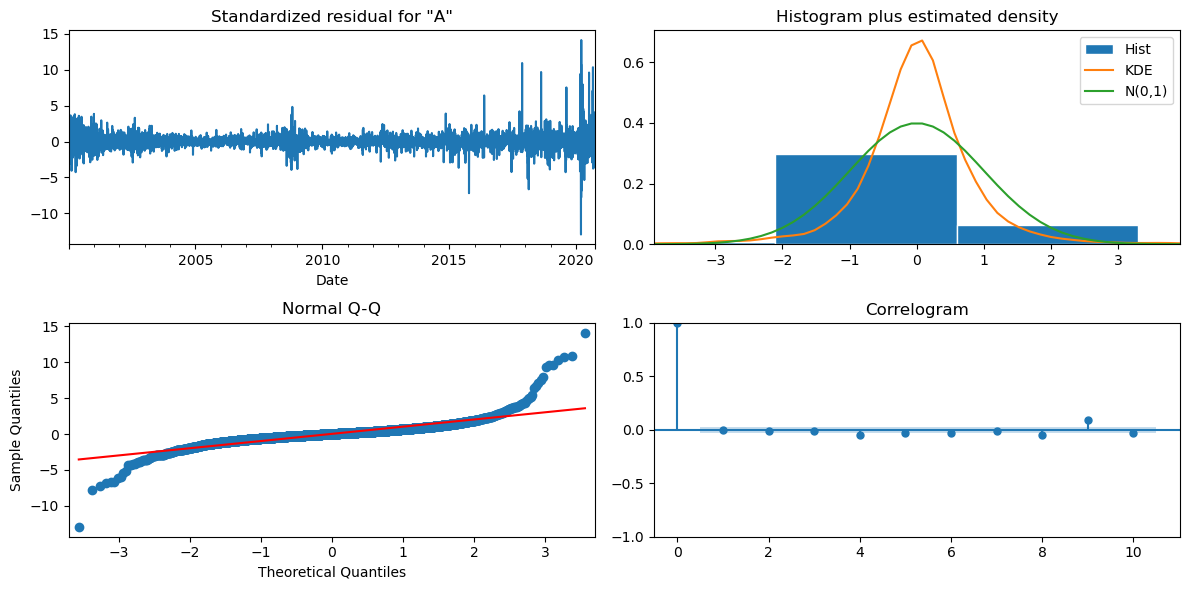

In [30]:
fig = arima_model.plot_diagnostics()
fig.set_size_inches(12,6)
fig.tight_layout()

### Testing Loop

In [32]:
#ranges
p_values = range(0,4)
d_values = range(1,3)
q_values = range(0,4)

pdq_test = list(itertools.product(p_values, d_values, q_values))
pdq_test

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3)]

In [34]:
best_aic = float('inf')

best_pdq = (0,0,0)

for pdq in pdq_test:
    model = tsa.ARIMA(train, order = pdq)
    result = model.fit()
    print(pdq, result.aic)

    if result.aic < best_aic:
        best_aic = result.aic
        best_pdq = pdq

print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 1, 0) 13194.041584611674
(0, 1, 1) 13153.709425922425
(0, 1, 2) 13155.324253634506
(0, 1, 3) 13155.71822312253
(0, 2, 0) 17387.777156816923
(0, 2, 1) 13199.30036324444
(0, 2, 2) 13157.879854198793
(0, 2, 3) 13159.36645685384
(1, 1, 0) 13154.59508634957
(1, 1, 1) 13151.308457330568
(1, 1, 2) 13146.10028061416
(1, 1, 3) 13145.293847453304
(1, 2, 0) 15538.486685237955
(1, 2, 1) 13158.892858528678
(1, 2, 2) 13203.206437453395


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 3) 13155.74775156158
(2, 1, 0) 13155.656401338554
(2, 1, 1) 13145.574982394875
(2, 1, 2) 13146.90362794698


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3) 13146.027278479221
(2, 2, 0) 14827.538519300353
(2, 2, 1) 13159.782369852364
(2, 2, 2) 13154.990285418231


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 3) 13147.864856207969
(3, 1, 0) 13157.117434401549
(3, 1, 1) 13145.92084031537


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2) 13144.346516712752


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3) 13130.179532885502
(3, 2, 0) 14520.691466022956
(3, 2, 1) 13161.107262381269
(3, 2, 2) 13156.78044849919


/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 2, 3) 13139.36020400539
Best AIC: 13130.179532885502
Best pdq: (3, 1, 3)


## Model 2:

In [38]:
# Best Results:
p = 3
d = 1
q = 3

In [39]:
# define/fit model
model_2 = tsa.ARIMA(train, order=(p,d,q)).fit()

/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jeffrey/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Diagnostic plots

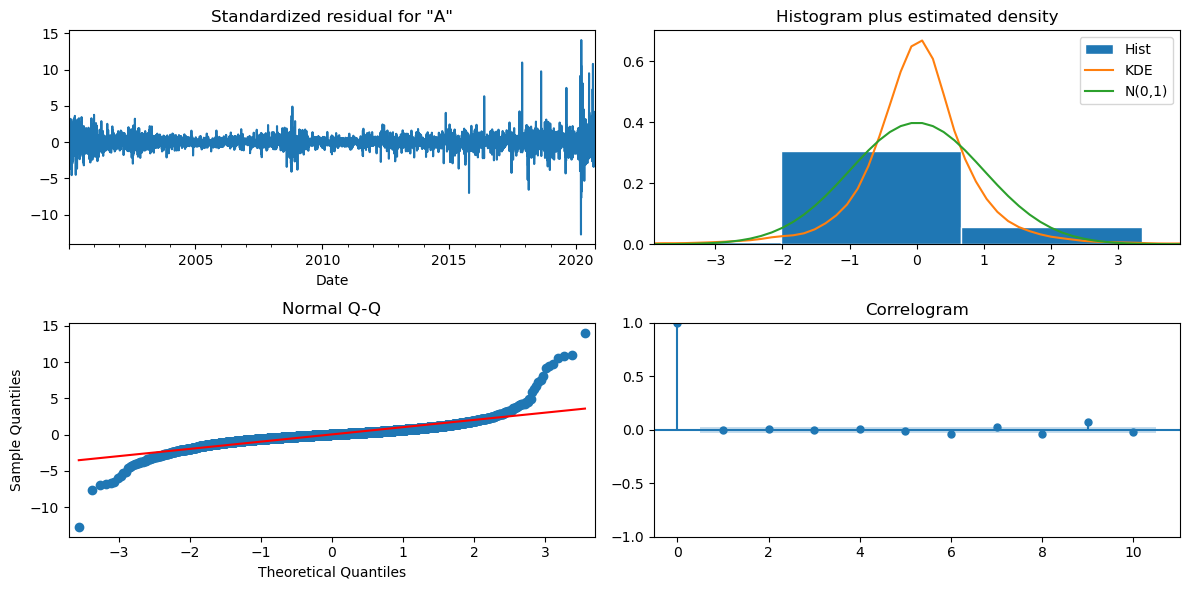

In [40]:
fig = model_2.plot_diagnostics()
fig.set_size_inches(12,6)
fig.tight_layout()

In [ ]:
#forecast

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4.310
- MSE = 27.881
- RMSE = 5.280
- R^2 = -1.178
- MAPE = 2.96%


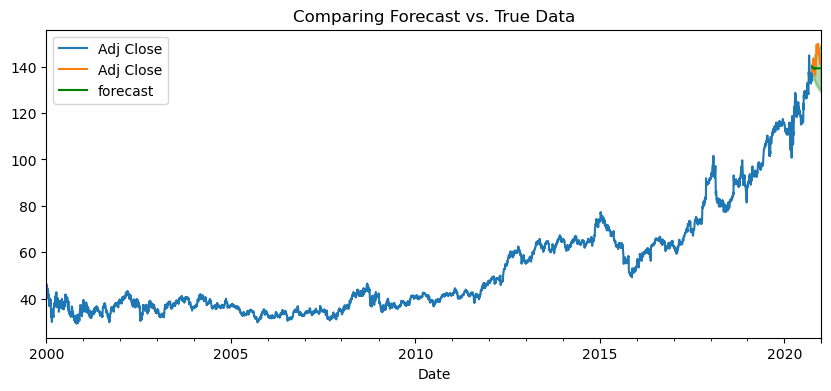

In [41]:
forecast2 = model_2.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, forecast2)
regression_metrics_ts(test, forecast2['mean'])

## Model Comparison

Model 1:
- MAE = 2.709
- MSE = 12.284
- RMSE = 3.505
- R^2 = 0.041
- MAPE = 1.87%

Model 2:
- MAE = 4.310
- MSE = 27.881
- RMSE = 5.280
- R^2 = -1.178
- MAPE = 2.96%

Conclusion:
Based on the provided metrics, Model 1 appears to perform better than Model 2. It has lower values for MAE, MSE, RMSE, and MAPE, as well as a higher R².